In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline


In [ ]:
class SymbolGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.available_symbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', 'x', 'y', 't', ',']
        print(" Доступные символы:", self.available_symbols)
        
    def get_symbol_folder_name(self, char):
        """Преобразует символ в имя папки"""
        if char == 'x':
            return 'X'
        else:
            return char
    
    def get_random_symbol_image(self, char, test_split=0.8):

        folder_name = self.get_symbol_folder_name(char)
        symbol_dir = os.path.join(self.data_path, folder_name)
        
        if not os.path.exists(symbol_dir):
            print(f"⚠️  Папка {symbol_dir} не существует")
            return self.create_dummy_symbol(char)
        
        images = [f for f in os.listdir(symbol_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        images.sort()
        
        if not images:
            print(f" Нет изображений в {symbol_dir}")
            return self.create_dummy_symbol(char)

        start_index = int(len(images) * test_split)
        test_images = images[start_index:]
        
        if not test_images:
            test_images = images
        
        random_image = random.choice(test_images)
        img_path = os.path.join(symbol_dir, random_image)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Ошибка загрузки: {img_path}")
            return self.create_dummy_symbol(char)
            
        return img
    
    def create_dummy_symbol(self, char):

        img = np.ones((45, 45), dtype=np.uint8) * 255
        cv2.putText(img, char, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 0, 2)
        return img
    
    def generate_simple_sequence(self, length=6):

        simple_symbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']

        if length < 3:
            length = 3

        left_len = random.randint(1, length-2)
        right_len = length - left_len - 1
        
        left_part = ''.join(random.choices(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], k=left_len))
        operator = random.choice(['+', '-'])
        right_part = ''.join(random.choices(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], k=right_len))
        
        sequence = left_part + operator + right_part
        print(f" Генерируем простую последовательность: '{sequence}'")
        
        images = []
        for char in sequence:
            img = self.get_random_symbol_image(char)
            images.append(img)
        
        return sequence, images



✅ Класс SymbolGenerator создан


In [ ]:
def create_sequence_image(images, spacing=20):

    if not images:
        return np.ones((100, 100), dtype=np.uint8) * 255
    
    total_width = sum(img.shape[1] for img in images) + spacing * (len(images) - 1)
    max_height = max(img.shape[0] for img in images)
    
    sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255
    
    x_offset = 0
    for img in images:
        h, w = img.shape
        y_offset = (max_height - h) // 2
        sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
        x_offset += w + spacing
    
    return sequence_img

def center_in_45(image, target_size=45):

    h, w = image.shape

    if h == target_size and w == target_size:
        return image.copy()
    
    squared = np.zeros((target_size, target_size), dtype=np.uint8)

    y_offset = max((target_size - h) // 2, 0)
    x_offset = max((target_size - w) // 2, 0)

    actual_h = min(h, target_size - y_offset)
    actual_w = min(w, target_size - x_offset)

    squared[y_offset:y_offset+actual_h, x_offset:x_offset+actual_w] = image[:actual_h, :actual_w]
    
    return squared

def extract_symbols_from_sequence(image_sequence):

    kernel = np.ones((3, 3), np.uint8)
    img_gray = cv2.erode(image_sequence, kernel, iterations=1)
    img_gray = cv2.bitwise_not(img_gray)

    base = np.zeros((img_gray.shape[0], img_gray.shape[1]), dtype=np.uint8)
    base[0:img_gray.shape[0], 0:img_gray.shape[1]] = img_gray
    base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)
    
    img_rgb = base.copy()

    ret, thresh = cv2.threshold(img_rgb, 127, 255, 0)
    thresh = np.uint8(thresh)

    contours, hierarchy = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
    
    symbol_images = []

    for cnt in contours_sorted:
        x, y, w, h = cv2.boundingRect(cnt)

        if w * h > 50:
            symbol_crop = img_gray[y:y+h, x:x+w]
            symbol_images.append((x, symbol_crop))
    
    return symbol_images, img_rgb

print(" Функции для работы с изображениями созданы")

✅ Функции для работы с изображениями созданы


📝 Доступные символы: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', 'x', 'y', 't', ',']

🎲 СОЗДАНИЕ ТЕСТОВОЙ ПОСЛЕДОВАТЕЛЬНОСТИ
🎲 Генерируем простую последовательность: '71001+1'


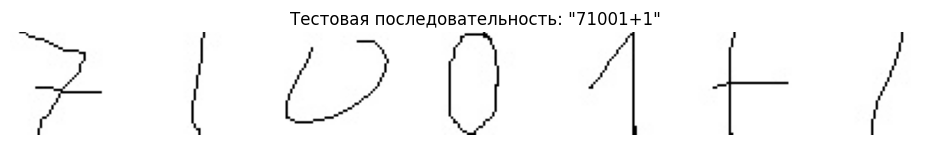

✅ Создана последовательность: '71001+1'
✅ Размер изображения: (45, 405)
✅ Количество символов: 7

📸 Символы по отдельности:


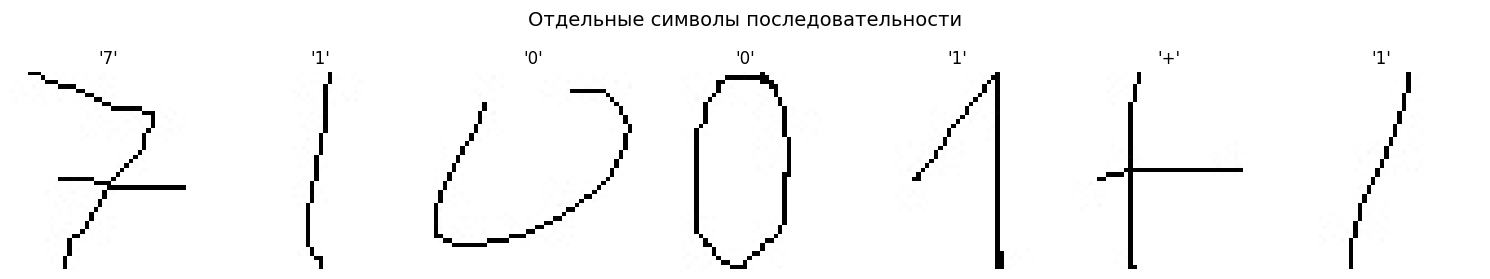

In [ ]:

DATA_PATH = r'C:\Users\engfile\image_processing\dz8\data'

generator = SymbolGenerator(DATA_PATH)



def create_random_balanced_sequence():

    digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    operators = ['+', '-']
    letters = ['x', 'y', 't']
    punctuation = [',']

    length = random.randint(6, 9)

    composition = []

    composition.extend(random.choices(digits, k=2))

    composition.append(random.choice(operators))

    remaining = length - 3
    if remaining > 0:

        remaining_pool = []

        remaining_pool.extend(random.choices(digits, k=min(remaining, 3)))
        remaining_pool.extend(random.choices(letters, k=min(remaining, 2)))
        if remaining > 5:
            remaining_pool.append(random.choice(punctuation))

        additional = random.sample(remaining_pool, min(remaining, len(remaining_pool)))
        composition.extend(additional)

    random.shuffle(composition)

    while composition[0] in operators:
        random.shuffle(composition)
    
    sequence = ''.join(composition)
    return sequence

print(" Генерируем несколько случайных последовательностей...")
random_sequences = []
for i in range(5):
    seq = create_random_balanced_sequence()
    random_sequences.append(seq)
    print(f"  Вариант {i+1}: '{seq}'")


test_sequence = random.choice(random_sequences)
print(f"\n Выбрана случайная последовательность: '{test_sequence}'")

print(f"\n Загружаем изображения символов:")
symbol_images = []
for i, char in enumerate(test_sequence, 1):
    print(f"  Символ {i} ('{char}')... ", end="")
    img = generator.get_random_symbol_image(char)
    symbol_images.append(img)
    print("✓")

# Склеиваем в одно изображение
sequence_image = create_sequence_image(symbol_images, spacing=15)

# Показываем результат
plt.figure(figsize=(12, 4))
plt.imshow(sequence_image, cmap='gray')
plt.title(f'Случайная тестовая последовательность: "{test_sequence}"')
plt.axis('off')
plt.show()

print(f"\n Создана последовательность: '{test_sequence}'")
print(f" Размер изображения: {sequence_image.shape}")
print(f" Количество символов: {len(test_sequence)}")

print(f"\n📸 Символы по отдельности:")
fig, axes = plt.subplots(1, len(test_sequence), figsize=(15, 3))

if len(test_sequence) > 1:
    for i, (char, img) in enumerate(zip(test_sequence, symbol_images)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Символ {i+1}: '{char}'")
        axes[i].axis('off')
else:
    axes.imshow(symbol_images[0], cmap='gray')
    axes.set_title(f"Символ 1: '{test_sequence[0]}'")
    axes.axis('off')

plt.suptitle('Отдельные символы последовательности', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nАнализ последовательности '{test_sequence}':")
digits_count = sum(1 for c in test_sequence if c.isdigit())
operators_count = sum(1 for c in test_sequence if c in ['+', '-'])
letters_count = sum(1 for c in test_sequence if c in ['x', 'y', 't'])
punctuation_count = sum(1 for c in test_sequence if c == ',')

print(f"  Цифры: {digits_count}")
print(f"  Операторы (+, -): {operators_count}")
print(f"  Буквы (x, y, t): {letters_count}")
print(f"  Пунктуация (,): {punctuation_count}")


🔍 ИЗВЛЕЧЕНИЕ СИМВОЛОВ ИЗ ИЗОБРАЖЕНИЯ
📝 Последовательность для обработки: '71001+1'
✅ Найдено символов: 7
✅ Ожидалось: 7


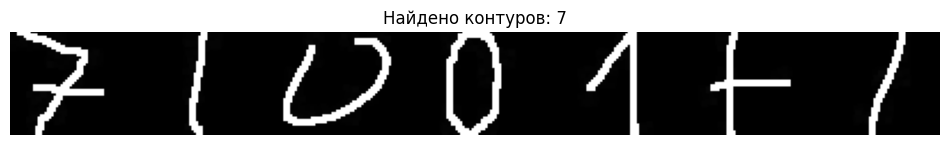


📸 Нормализованные символы (7 шт.):


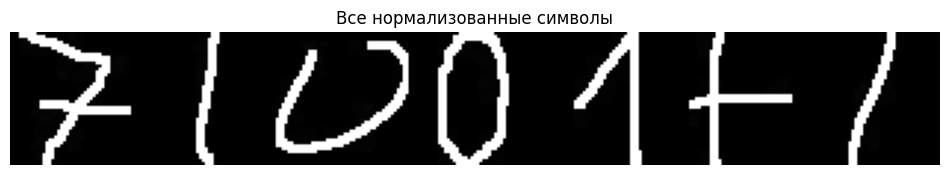

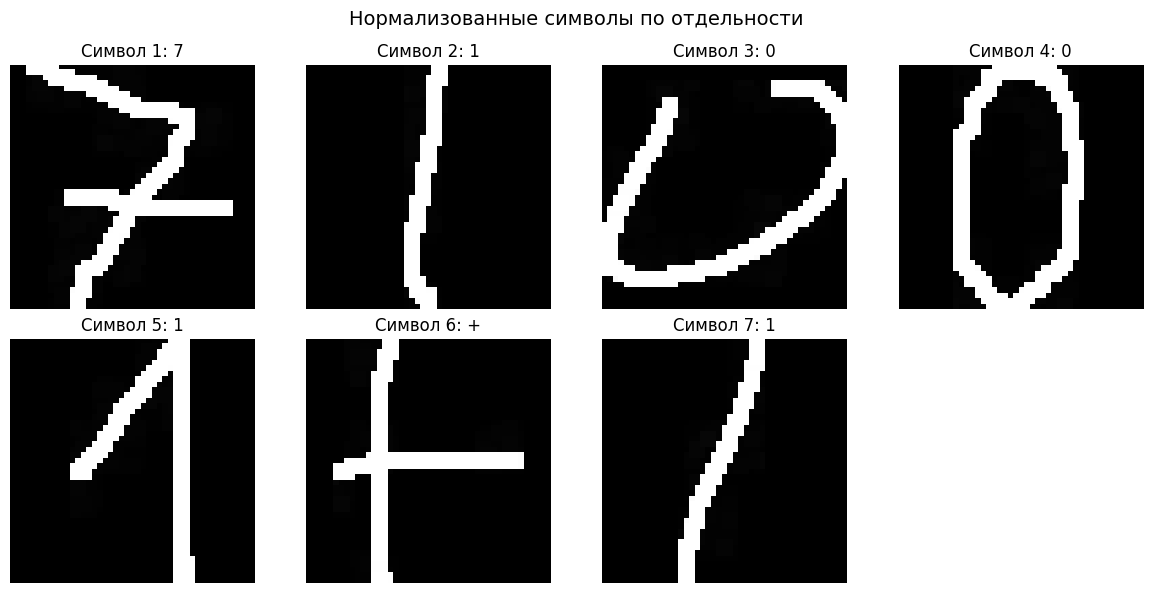


✅ Отлично! Количество символов совпадает


In [ ]:



print(f" Последовательность для обработки: '{test_sequence}'")

symbols_list, img_with_contours = extract_symbols_from_sequence(sequence_image)

print(f"Найдено символов: {len(symbols_list)}")
print(f"Ожидалось: {len(test_sequence)}")

plt.figure(figsize=(12, 4))
plt.imshow(img_with_contours)
plt.title(f'Найдено контуров: {len(symbols_list)}')
plt.axis('off')
plt.show()


normalized_symbols = []
for x, symbol_img in symbols_list:
    normalized = center_in_45(symbol_img)
    normalized_symbols.append((x, normalized))


normalized_symbols.sort(key=lambda x: x[0])


if normalized_symbols:
    print(f"\n Нормализованные символы ({len(normalized_symbols)} шт.):")

    all_symbols = np.hstack([img for _, img in normalized_symbols])
    plt.figure(figsize=(12, 4))
    plt.imshow(all_symbols, cmap='gray')
    plt.title(f'Все нормализованные символы')
    plt.axis('off')
    plt.show()

    num_to_show = min(8, len(normalized_symbols))
    cols = min(4, num_to_show)
    rows = (num_to_show + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, rows*3))
    axes = axes.flatten() if rows > 1 or cols > 1 else [axes]
    
    for i, (x, symbol_img) in enumerate(normalized_symbols[:num_to_show]):
        axes[i].imshow(symbol_img, cmap='gray')
        if i < len(test_sequence):
            axes[i].set_title(f'Символ {i+1}: {test_sequence[i]}')
        axes[i].axis('off')

    for i in range(num_to_show, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Нормализованные символы по отдельности', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(" Не найдено символов!")

if len(normalized_symbols) != len(test_sequence):
    print(f"\n  Внимание: количество символов не совпадает!")
    print(f"   Найдено: {len(normalized_symbols)}, Ожидалось: {len(test_sequence)}")
else:
    print(f"\n Отлично! Количество символов совпадает")

 ЗАГРУЗКА ВСЕХ ДАННЫХ
  '0' 


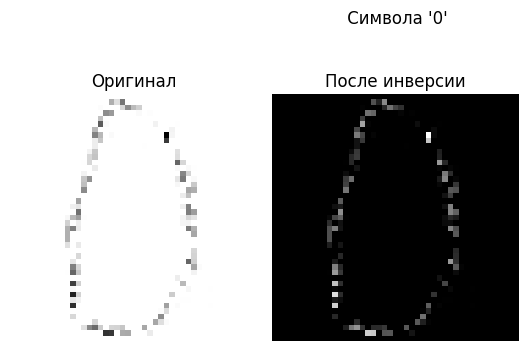

  '1' 


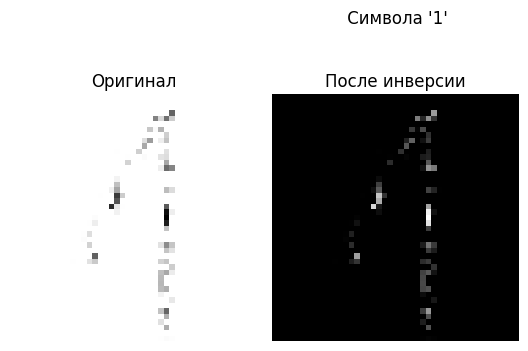

  '2' 


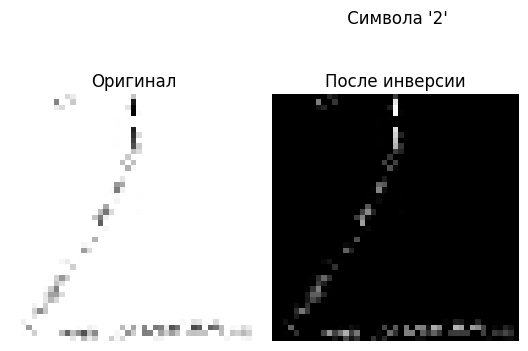

  '3' 


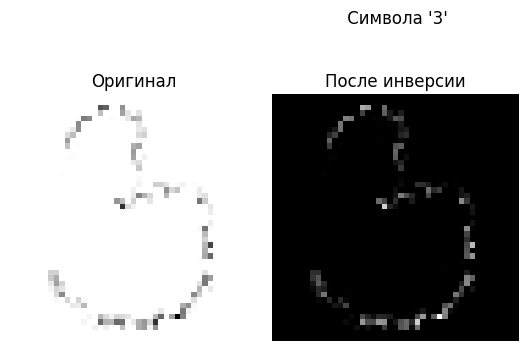

  '4' 


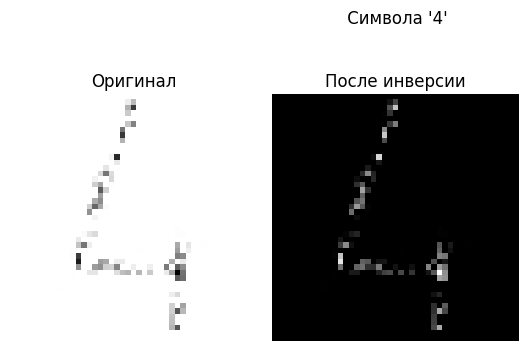

  '5' 


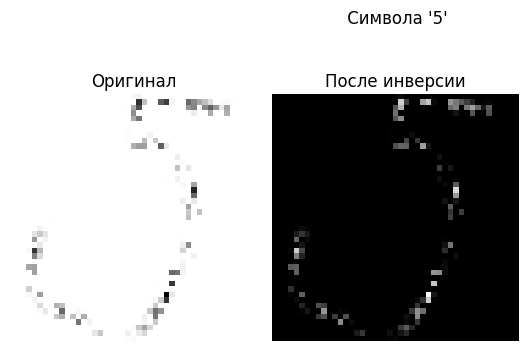

  '6' 


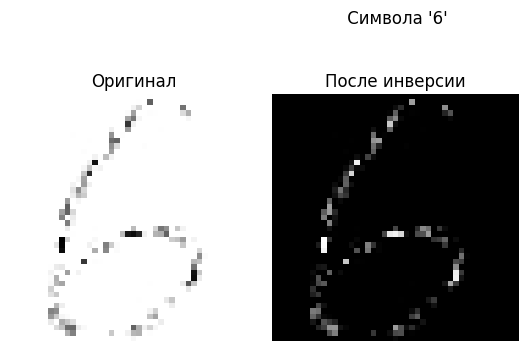

  '7' 


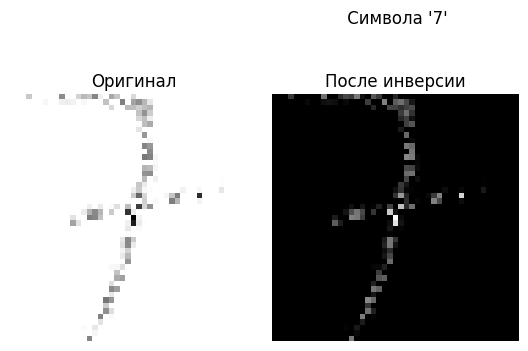

  '8' 


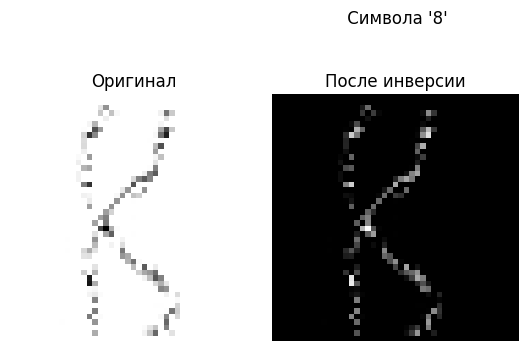

  '9' 


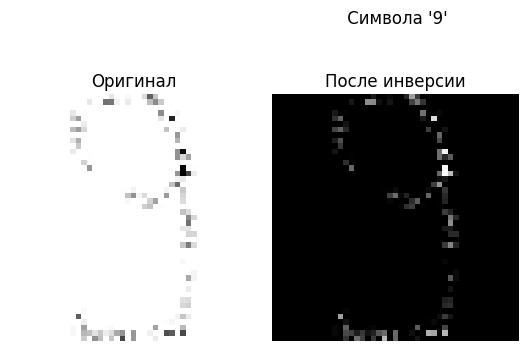

  '+' 


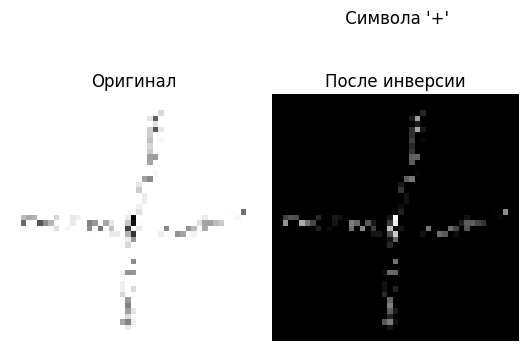

  '-' 


KeyboardInterrupt: 

: 

In [ ]:

print(" ЗАГРУЗКА ВСЕХ ДАННЫХ")


def load_all_train_data(data_path, symbols=None):
    """Загружаем ВСЕ тренировочные данные (первые 80% каждого символа)"""
    if symbols is None:
        symbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', 'X', 't', 'y', ',']
    
    X_train = []
    y_train = []
    

    
    total_loaded = 0
    for folder in symbols:
        folder_path = os.path.join(data_path, folder)
        
        if not os.path.exists(folder_path):
            print(f"  Пропускаем: {folder} (папки нет)")
            continue

        all_images = [f for f in os.listdir(folder_path) 
                     if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        
        if not all_images:
            print(f"  Пропускаем: {folder} (нет изображений)")
            continue
        
        all_images.sort()

        train_count = int(len(all_images) * 0.8)
        train_images = all_images[:train_count]
        
        symbol_char = 'x' if folder == 'X' else folder
        
        print(f"  '{symbol_char}' ")

        
        loaded = 0
        for img_name in train_images:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:

                img_inverted = cv2.bitwise_not(img)

                img_squared = make_square(img_inverted)

                X_train.append(img_squared.flatten())
                y_train.append(symbol_char)
                
                loaded += 1
                total_loaded += 1
        


        if loaded > 0:
            plt.figure(figsize=(8, 4))

            sample_path = os.path.join(folder_path, train_images[0])
            sample_orig = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
            
            if sample_orig is not None:
                sample_inv = cv2.bitwise_not(sample_orig)
                sample_sq = make_square(sample_inv)
                
                plt.subplot(1, 3, 1)
                plt.imshow(sample_orig, cmap='gray')
                plt.title('Оригинал')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(sample_inv, cmap='gray')
                plt.title('После инверсии')
                plt.axis('off')
                
               
                
                plt.suptitle(f" Символа '{symbol_char}'", fontsize=12)
                plt.tight_layout()
                plt.show()
    
    print(f"\n" + "="*50)
    print(f" ЗАГРУЖЕНО ВСЕГО: {total_loaded} изображений")
    print(f" УНИКАЛЬНЫХ СИМВОЛОВ: {len(set(y_train))}")

    print("\n Статистика по символам:")
    unique, counts = np.unique(y_train, return_counts=True)
    for char, count in zip(unique, counts):
        print(f"  '{char}': {count:4d} изображений")
    

    plt.tight_layout()
    plt.show()
    
    return np.array(X_train), np.array(y_train)


X_train, y_train = load_all_train_data(DATA_PATH)



In [ ]:

print(" ОБУЧЕНИЕ МОДЕЛЕЙ KNN")


if len(X_train) == 0:
    print(" Нет данных для обучения!")
    models = {}
else:
    models = {}
    
    k_values = [1, 3, 5, 7]
    
    for k in k_values:
        print(f"\nОбучаем KNN с k={k}...")

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        models[f'knn_{k}'] = knn

        sample_size = min(1000, len(X_train))
        predictions = knn.predict(X_train[:sample_size])
        accuracy = accuracy_score(y_train[:sample_size], predictions)

    
    print(f"\n Обучено {len(models)} моделей")


    


🤖 ОБУЧЕНИЕ МОДЕЛЕЙ KNN

Обучаем KNN с k=1...

Обучаем KNN с k=3...

Обучаем KNN с k=5...

Обучаем KNN с k=7...

🎉 Обучено 4 моделей

📈 СРАВНЕНИЕ МОДЕЛЕЙ НА ТРЕНИРОВОЧНЫХ ДАННЫХ
knn_1    |    100.0%
knn_3    |     83.0%
knn_5    |     64.0%
knn_7    |     58.7%


In [160]:
print("\n" + "="*70)
print("🔮 РАСПОЗНАВАНИЕ ТЕСТОВОЙ ПОСЛЕДОВАТЕЛЬНОСТИ")
print("="*70)

print(f"Последовательность: '{test_sequence}'")
print(f"Ожидается символов: {len(test_sequence)}")
print(f"Найдено символов: {len(normalized_symbols)}")

if len(normalized_symbols) != len(test_sequence):
    print(f"\n Внимание: количество символов не совпадает!")
    print("   Продолжаем распознавание, но точность может быть некорректной")
else:
    print(f"\nКоличество символов совпадает")

all_results = {}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f" МОДЕЛЬ: {model_name.upper()}")
    print(f"{'='*60}")
    
    predictions = []
    details = []

    for i, (x, symbol_img) in enumerate(normalized_symbols):

        
        img_flat = symbol_img.flatten().reshape(1, -1)
        predicted_char = model.predict(img_flat)[0]
        predictions.append(predicted_char)
        
        if hasattr(model, 'kneighbors'):
            distances, indices = model.kneighbors(img_flat, n_neighbors=3)
            neighbors = [y_train[idx] for idx in indices[0]]
        else:
            neighbors = []

        detail = {
            'position': i + 1,
            'predicted': predicted_char,
            'neighbors': neighbors,
            'brightness': np.mean(symbol_img)
        }
        
        if i < len(test_sequence):
            detail['expected'] = test_sequence[i]
            detail['is_correct'] = predicted_char == test_sequence[i]
        
        details.append(detail)

        if i < len(test_sequence):
            expected = test_sequence[i]
            status = "" if predicted_char == expected else ""
            print(f"  Символ {i+1}: {status} '{expected}' → '{predicted_char}'")
            
            if predicted_char != expected and neighbors:
                print(f"       Ближайшие соседи: {neighbors}")
        else:
            print(f"  Символ {i+1}: '{predicted_char}'")

    predicted_text = ''.join(predictions)
    print(f"\n   Полное предсказание: '{predicted_text}'")

    if len(predicted_text) == len(test_sequence):
        correct = sum(1 for a, b in zip(test_sequence, predicted_text) if a == b)
        accuracy = correct / len(test_sequence)
        print(f"   Точность: {accuracy:.1%} ({correct}/{len(test_sequence)})")
        
        if accuracy < 1.0:
            print(f"   Ошибки распознавания:")
            for idx, (true, pred) in enumerate(zip(test_sequence, predicted_text)):
                if true != pred:
                    print(f"    Позиция {idx+1}: '{true}' → '{pred}'")
    else:
        accuracy = 0
        print(f"    Точность не может быть вычислена")
    
    all_results[model_name] = {
        'text': predicted_text,
        'accuracy': accuracy if len(predicted_text) == len(test_sequence) else 0,
        'details': details
    }


🔮 РАСПОЗНАВАНИЕ ТЕСТОВОЙ ПОСЛЕДОВАТЕЛЬНОСТИ
Последовательность: '71001+1'
Ожидается символов: 7
Найдено символов: 7

Количество символов совпадает

🧠 МОДЕЛЬ: KNN_1
  Символ 1:  '7' → '7'
  Символ 2:  '1' → '1'
  Символ 3:  '0' → '0'
  Символ 4:  '0' → '0'
  Символ 5:  '1' → '1'
  Символ 6:  '+' → '+'
  Символ 7:  '1' → '1'

   Полное предсказание: '71001+1'
   Точность: 100.0% (7/7)

🧠 МОДЕЛЬ: KNN_3
  Символ 1:  '7' → '7'
  Символ 2:  '1' → '1'
  Символ 3:  '0' → '0'
  Символ 4:  '0' → '0'
  Символ 5:  '1' → '1'
  Символ 6:  '+' → '+'
  Символ 7:  '1' → '1'

   Полное предсказание: '71001+1'
   Точность: 100.0% (7/7)

🧠 МОДЕЛЬ: KNN_5
  Символ 1:  '7' → '7'
  Символ 2:  '1' → '1'
  Символ 3:  '0' → '0'
  Символ 4:  '0' → '0'
  Символ 5:  '1' → '1'
  Символ 6:  '+' → '+'
  Символ 7:  '1' → '1'

   Полное предсказание: '71001+1'
   Точность: 100.0% (7/7)

🧠 МОДЕЛЬ: KNN_7
  Символ 1:  '7' → '7'
  Символ 2:  '1' → '1'
  Символ 3:  '0' → '0'
  Символ 4:  '0' → '0'
  Символ 5:  '1' → '1'
  С


📊 ИТОГОВЫЕ РЕЗУЛЬТАТЫ

📝 Исходная последовательность: '71001+1'

Модель   | Точность   | Результат
--------------------------------------------------
knn_1    | 100.0%     | '71001+1'
knn_3    | 100.0%     | '71001+1'
knn_5    | 100.0%     | '71001+1'
knn_7    | 100.0%     | '71001+1'

🏆 Лучшая модель: knn_1 (точность: 100.0%)

🎨 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ (KNN_1)


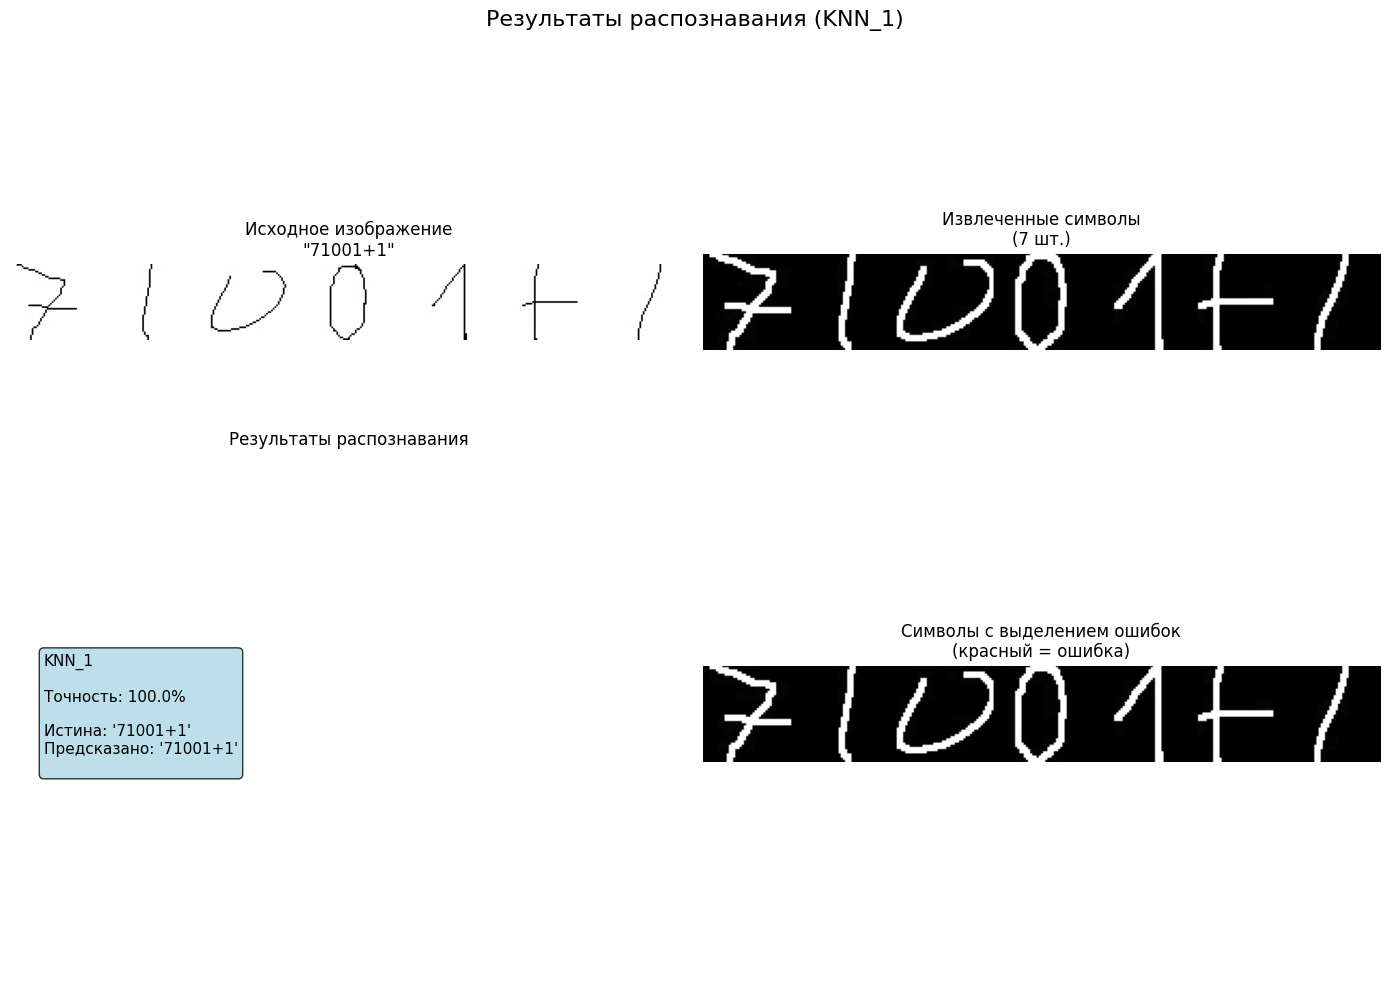


✅ РАБОТА ЗАВЕРШЕНА!


In [ ]:

print(" ИТОГОВЫЕ РЕЗУЛЬТАТЫ")


print(f"\n Исходная последовательность: '{test_sequence}'")

print(f"\n{'Модель':<8} | {'Точность':<10} | {'Результат'}")
print("-" * 50)

for model_name, result in all_results.items():
    acc_text = f"{result['accuracy']:.1%}" if result['accuracy'] > 0 else "N/A"
    print(f"{model_name:<8} | {acc_text:<10} | '{result['text']}'")

if all_results:
    valid_results = {k: v for k, v in all_results.items() if v['accuracy'] > 0}
    if valid_results:
        best_model = max(valid_results.items(), key=lambda x: x[1]['accuracy'])
        print(f"\n Лучшая модель: {best_model[0]} (точность: {best_model[1]['accuracy']:.1%})")

if all_results:

    if valid_results:
        model_to_show = best_model[0]
        result_to_show = best_model[1]
    else:
        model_to_show = list(all_results.keys())[0]
        result_to_show = all_results[model_to_show]
    

    print(f" ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ({model_to_show.upper()})")
  
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].imshow(sequence_image, cmap='gray')
    axes[0, 0].set_title(f'Исходное изображение\n"{test_sequence}"')
    axes[0, 0].axis('off')

    if normalized_symbols:
        all_symbols_img = np.hstack([img for _, img in normalized_symbols])
        axes[0, 1].imshow(all_symbols_img, cmap='gray')
        axes[0, 1].set_title(f'Извлеченные символы\n({len(normalized_symbols)} шт.)')
        axes[0, 1].axis('off')
    else:
        axes[0, 1].text(0.5, 0.5, "Символы не найдены", 
                       ha='center', va='center', fontsize=12)
        axes[0, 1].axis('off')
        axes[0, 1].set_title('Извлеченные символы')

    axes[1, 0].axis('off')
    result_text = f"{model_to_show.upper()}\n\n"
    
    if result_to_show['accuracy'] > 0:
        result_text += f"Точность: {result_to_show['accuracy']:.1%}\n"
    result_text += f"\nИстина: '{test_sequence}'\n"
    result_text += f"Предсказано: '{result_to_show['text']}'\n"
    
    if result_to_show['accuracy'] > 0 and result_to_show['accuracy'] < 1.0:
        result_text += "\nОшибки:\n"
        for i, (true, pred) in enumerate(zip(test_sequence, result_to_show['text'])):
            if true != pred:
                result_text += f"  Символ {i+1}: '{true}' → '{pred}'\n"
    
    axes[1, 0].text(0.05, 0.5, result_text, 
                   fontsize=11, 
                   transform=axes[1, 0].transAxes,
                   verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1, 0].set_title('Результаты распознавания')

    axes[1, 1].axis('off')
    
    if normalized_symbols and len(result_to_show['text']) == len(normalized_symbols):

        color_img = np.zeros((45, 45 * len(normalized_symbols), 3), dtype=np.uint8)
        
        for i, (x, symbol_img) in enumerate(normalized_symbols):

            color_img[:, i*45:(i+1)*45, 0] = symbol_img
            color_img[:, i*45:(i+1)*45, 1] = symbol_img
            color_img[:, i*45:(i+1)*45, 2] = symbol_img

            if i < len(test_sequence) and i < len(result_to_show['text']):
                if test_sequence[i] != result_to_show['text'][i]:

                    color_img[0:3, i*45:(i+1)*45, 0] = 255
                    color_img[0:3, i*45:(i+1)*45, 1] = 0
                    color_img[0:3, i*45:(i+1)*45, 2] = 0
                    
                    color_img[-3:, i*45:(i+1)*45, 0] = 255
                    color_img[-3:, i*45:(i+1)*45, 1] = 0
                    color_img[-3:, i*45:(i+1)*45, 2] = 0
        
        axes[1, 1].imshow(color_img)
        axes[1, 1].set_title('Символы с выделением ошибок\n(красный = ошибка)')
    else:
        axes[1, 1].text(0.5, 0.5, "Визуализация невозможна\n(разное количество символов)", 
                       ha='center', va='center', fontsize=12)
        axes[1, 1].set_title('Символы с выделением ошибок')
    
    axes[1, 1].axis('off')
    
    plt.suptitle(f"Результаты распознавания ({model_to_show.upper()})", fontsize=16)
    plt.tight_layout()
    plt.show()

